# Sentiment Analysis on Alexa Reviews

#### Imports

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import string

import nltk
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv("../data/amazon_alexa.tsv", sep="\t")

## Data Exploration

In [3]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
df.shape

(3150, 5)

In [5]:
df.feedback.value_counts()

feedback
1    2893
0     257
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [7]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


<Axes: >

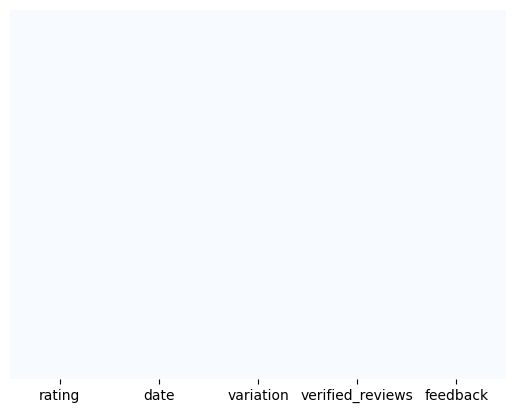

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

In [13]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [12]:
df.dropna(axis=0, inplace=True)

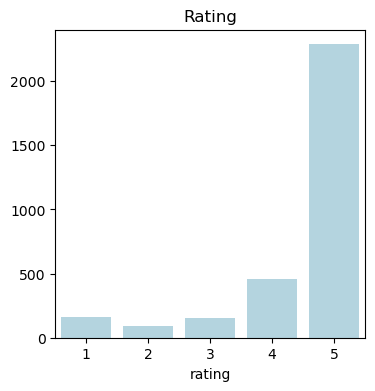

In [14]:
plt.figure(figsize=(4,4))
sns.countplot(x="rating", data=df, color="lightblue")


plt.ylabel(None)

plt.title("Rating")
plt.show()

In [15]:
df["length"] = df["verified_reviews"].apply(str).apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


/home/ubuntu/miniconda3/envs/cct/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


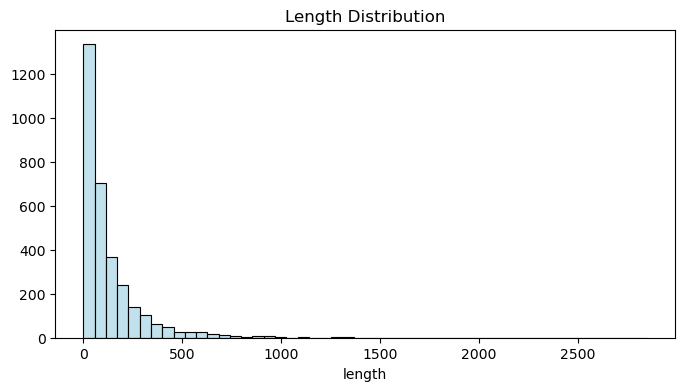

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(df.length, color="lightblue", bins=50)


plt.ylabel(None)

plt.title("Length Distribution")
plt.show()

In [17]:
df.describe()

,rating,feedback,length
count,3149.000000,3149.000000,3149.000000
mean,4.463957,0.918704,132.090187
std,1.067773,0.273332,182.114569
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,165.000000
max,5.000000,1.000000,2851.000000


In [18]:
longest_message = df.loc[df['length'].idxmax(), 'verified_reviews']
print("The longest message is:\n\n", longest_message, sep="")

The longest message is:

Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This or

#### Wordcloud

In [19]:
df_pos = df[df["feedback"]==1]
df_neg = df[df["feedback"]==0]

In [20]:
df_pos_lst = list(df_pos["verified_reviews"])
df_neg_lst = list(df_neg["verified_reviews"])

In [21]:
pos_words = " ".join(map(str, df_pos_lst))
neg_words = " ".join(map(str, df_neg_lst))

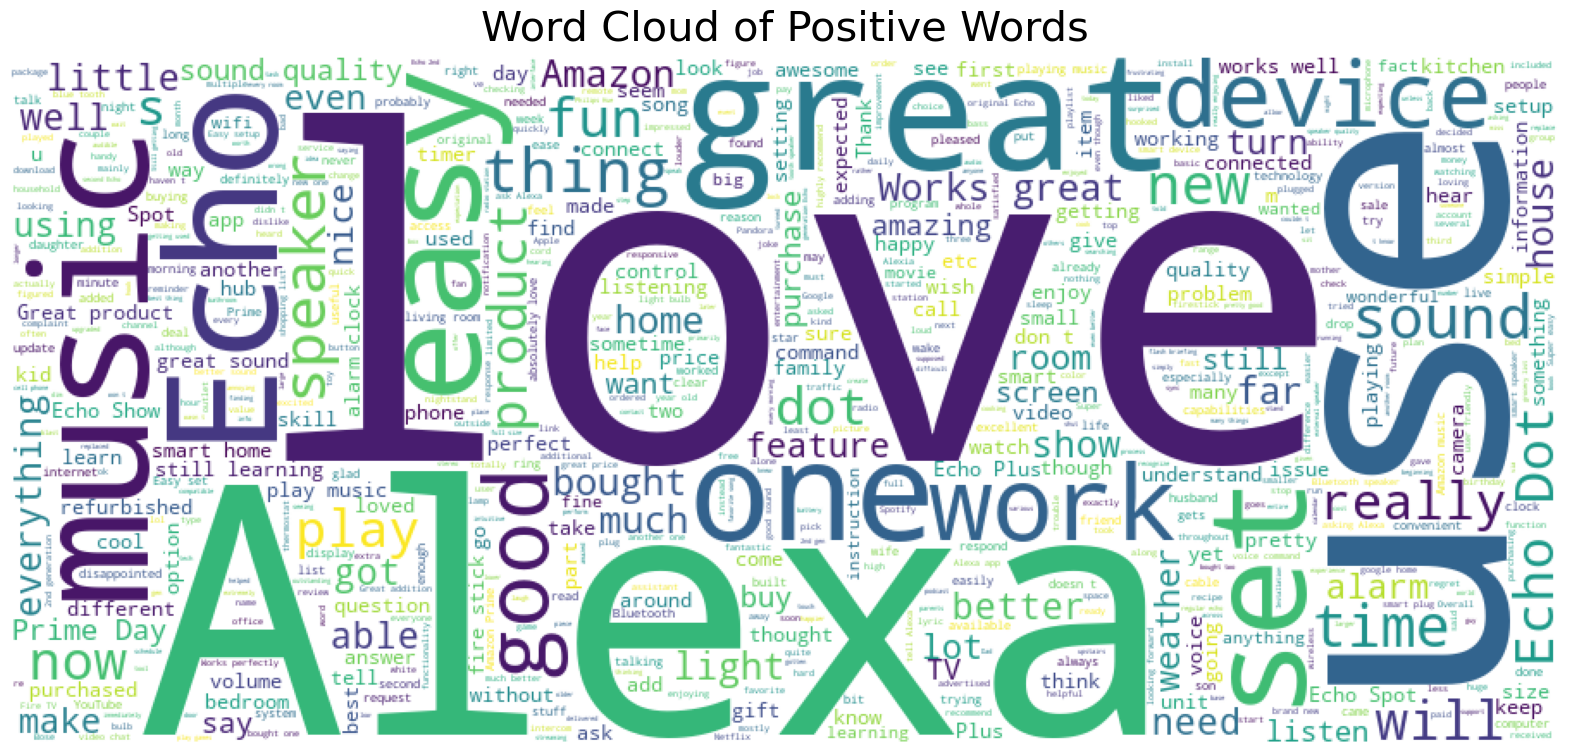

In [67]:
wordcloud = WordCloud(
    width=900,
    height=400,
    background_color="white",
    max_words=2000,
    colormap="viridis",
    #collocations=False,
    contour_width=3,
    contour_color='steelblue',

)



plt.figure(figsize=(20,20))
plt.imshow(wordcloud.generate(pos_words))

plt.title("Word Cloud of Positive Words", fontsize=30, y =1.01)
plt.axis("off")
plt.show()

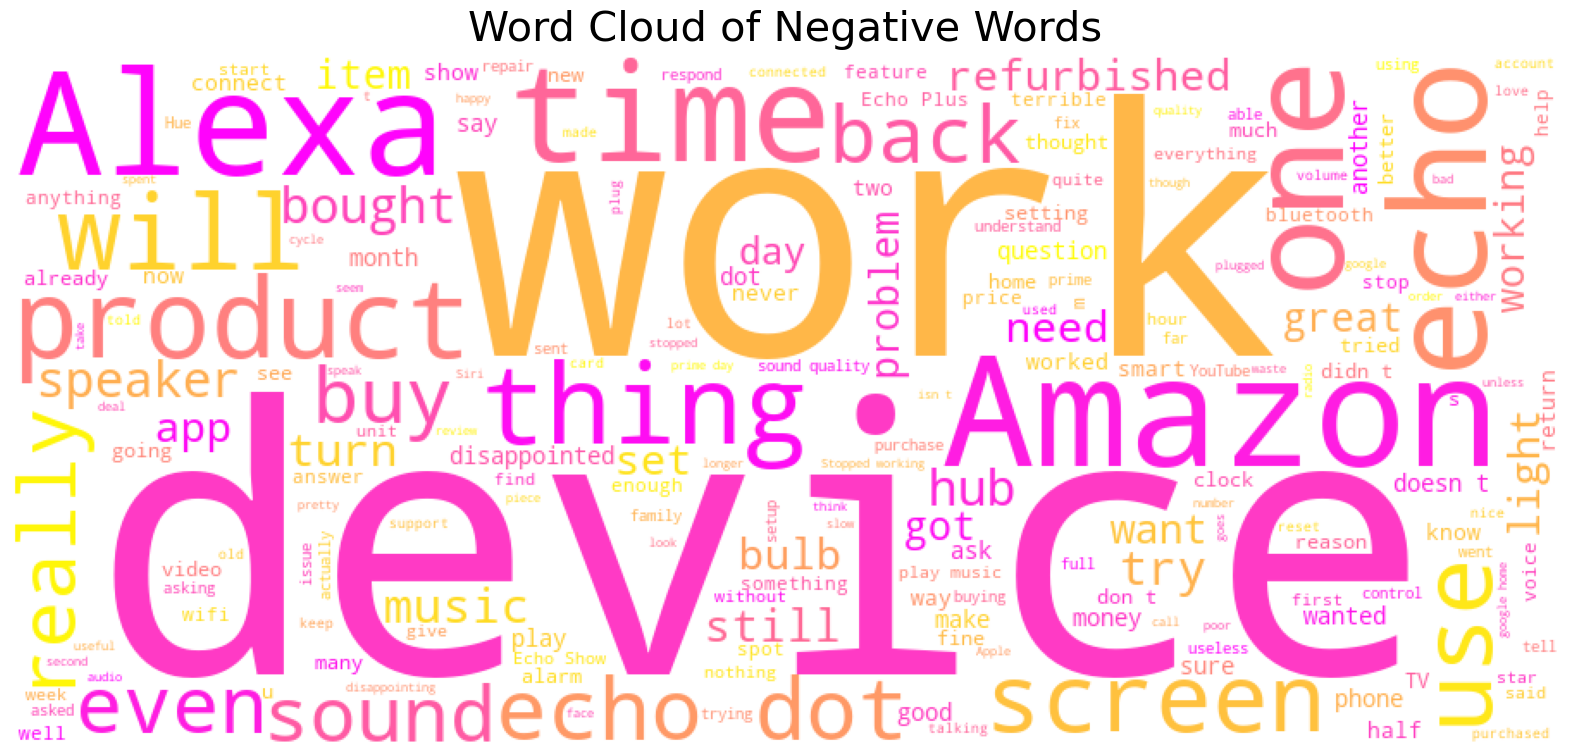

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.generate(neg_words))

plt.title("Word Cloud of Negative Words", fontsize=30, y =1.01)
plt.axis("off")
plt.show()

## Data Cleaning

In [24]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
def review_clean(review):
    review = str(review)
    review_no_punc = [char for char in review if char not in string.punctuation]
    review_no_punc = "".join(review_no_punc)
    review_no_punc = [word for word in review_no_punc.split() if word.lower() not in stopwords.words("english")]
    return review_no_punc

In [26]:
df_clean = df["verified_reviews"].apply(review_clean)

In [27]:
df_clean[5]

['received',
 'echo',
 'gift',
 'needed',
 'another',
 'Bluetooth',
 'something',
 'play',
 'music',
 'easily',
 'accessible',
 'found',
 'smart',
 'speaker',
 'Can’t',
 'wait',
 'see',
 'else']

In [28]:
vectorizer = CountVectorizer(analyzer = review_clean)
reviews_count_vect = vectorizer.fit_transform(df["verified_reviews"])

In [31]:
print(vectorizer.get_feature_names_out())

['072318' '1' '10' ... '😬' '😳' '🤓']


In [29]:
reviews_count_vect.shape

(3149, 5211)

In [32]:
reviews = pd.DataFrame(reviews_count_vect.toarray())

In [33]:
X = reviews

In [34]:
y = df["feedback"]

## Modelling

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### NaiveBaise model

In [50]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

<Axes: >

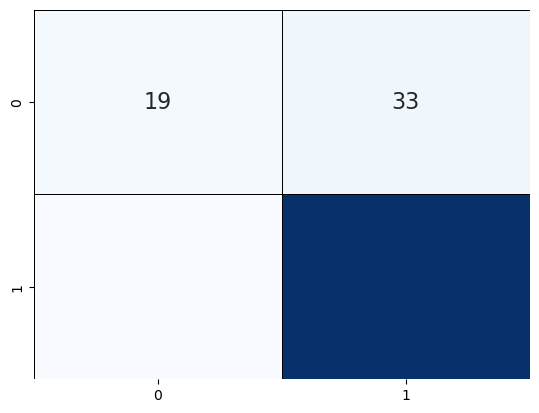

In [59]:
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')

In [52]:
cm

array([[ 19,  33],
       [  9, 569]])

In [54]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.68      0.37      0.47        52
           1       0.95      0.98      0.96       578

    accuracy                           0.93       630
   macro avg       0.81      0.67      0.72       630
weighted avg       0.92      0.93      0.92       630



#### Logistic Regression

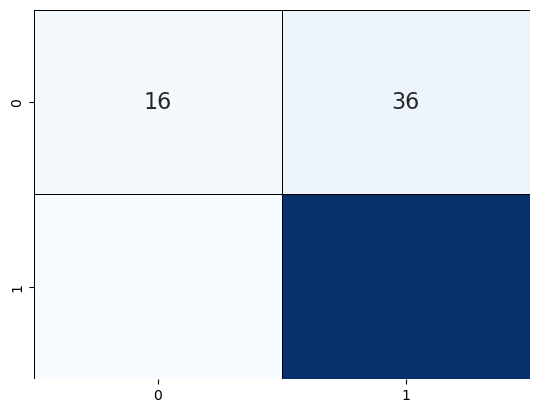

In [63]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')
plt.show()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.31      0.44        52
           1       0.94      0.99      0.97       578

    accuracy                           0.93       630
   macro avg       0.85      0.65      0.70       630
weighted avg       0.93      0.93      0.92       630

